# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. Если вы строите интерактивные графики, их стоит прислать в формате html.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.




**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [2]:
# Bot check

# HW_ID: fpmi_ad7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [4]:
import warnings
import graphviz
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

Например, вместо/дополнительно признака $x_j$ рассматривать признак $f(x_j)$, для указанных выше типов функций.

* Применять монотонные функции от одного признака не имеет смысла, так как множество вариантов разбиения не меняется
* Применять немонотонные функции от одного признака может иметь смысл, так как это позволяет учесть сложные разбиения.
* Рассматривать линейные функции от нескольких признаков может иметь смысл. Например при истинной линейной зависимости, хорошо приблизить порогами ее довольно-таки трудно.
* Применять нелинейные функции от нескольких признаков есть смысл, если это более явно поможет разделить множество на подмножества. Например, дано производительность рабочего в деталях/час и время работы рабочего, тогда имеет смысл рассмотреть функцию произведения производительности и времени работы, получив колво сделанных деталей и по нему разделить множество.
* Стандартизацию признаков также применять не имеет особого смысла, так как искать точку разделения данных все равно на нормализованных или на обычных данных, в обоих случаях вы получите одно и то же дерево.
* Применять преобразования категориальных признаков имеет смысл, так как если этого не делать, у решающего дерева может появиться много листьев, для этого, множества, являющиеся областью значения признака, разбивают на непересекающиеся множества. Но есть небольшие особенности. Например, если значений категориального признака очень много, то применять one-hot encoding - может быть не очень хорошей идеей. Можно применять другие энкодинги, например, mean encoding.

---
### Задача 2.

Рассмотрим данные из <a href="https://miptstats.github.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

In [5]:
data = pd.read_csv('/Users/carevivan/Downloads/Bike-Sharing-Dataset/day.csv')
data = data[['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum','windspeed', 'cnt']]
tmp, test = train_test_split(data, test_size=0.2)
train, valid = train_test_split(tmp, test_size=0.25)
train.head(5)

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
330,4,11,0,0,0,1,0.459167,0.455800,0.698333,0.208954,3071
382,1,1,0,3,1,1,0.303333,0.275254,0.443333,0.415429,3376
227,3,8,0,2,1,1,0.700833,0.645837,0.578333,0.236329,4725
184,3,7,1,1,0,2,0.726667,0.665417,0.637917,0.081479,6043
192,3,7,0,2,1,1,0.794167,0.739275,0.559167,0.200254,4258


Выполните необходимые преобразования признаков.

*Замечание.* Если в валидационной и/или тестовой частях есть "большие" выбросы, их стоит убрать. Наша модель не должна пытаться их предсказать, но в то же время выбросы вносят существенный вклад в значение метрики. 

Как обычно разделим признаки на категориальные, вещественные и таргетный.

In [6]:
categorial_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']  # категориальные признаки
real_features = ['temp', 'atemp', 'hum', 'windspeed']  # вещественные признаки
target_feature = 'cnt'  # целевой признак

Теперь уберем большие выбросы из данных, то есть оставим данные между 2-м и 98-м процентилями.

In [7]:
df_list = [train, valid, test]
for k in range(len(df_list)):
    low_quantil = df_list[k][real_features].quantile(q=.02)
    top_quantil = df_list[k][real_features].quantile(q=.98)
    flag = True
    for i in real_features:
        flag = (low_quantil[i] < df_list[k][i]) & (df_list[k][i] < top_quantil[i]) & flag
    df_list[k] = df_list[k].loc[flag]
train, valid, test = df_list

In [8]:
X_train = train[real_features + categorial_features]
y_train = train[target_feature]
X_test = test[real_features + categorial_features]
y_test = test[target_feature]

Обучите решающее дерево глубины 3 и визуализируйте его. 

*Рекомендуется сохранить визуализацию в html и отправить ее вместе с решением.*

In [9]:
def get_graphviz_graph(decision_tree_regressor):
    decision_tree_regressor.fit(X_train, y_train)
    dot_data = export_graphviz(decision_tree_regressor, class_names='cnt',
                               feature_names=X_train.columns, filled=True, 
                               rounded=True, special_characters=True)  
    return graphviz.Source(dot_data)

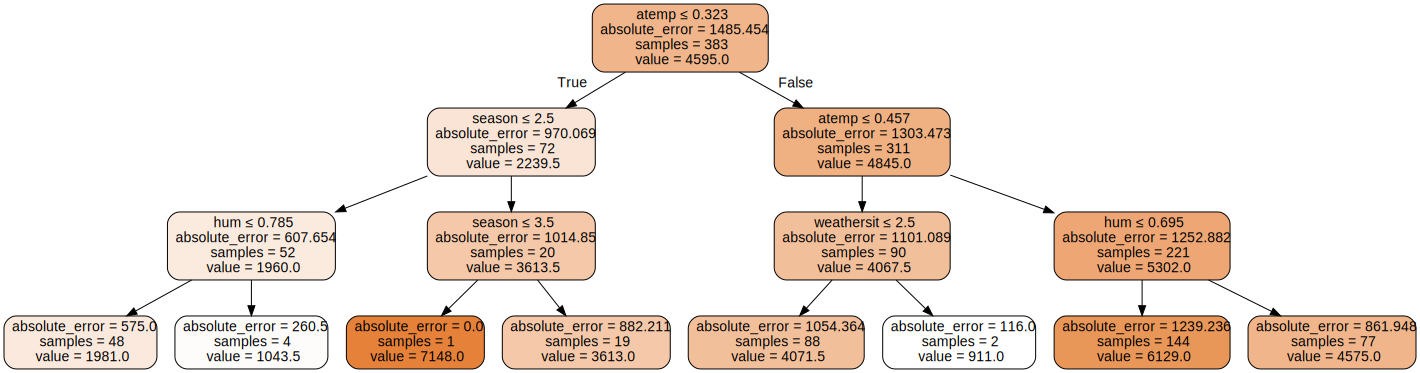

In [10]:
camera_regressor = DecisionTreeRegressor(
    criterion='absolute_error', max_depth=3
)
graph = get_graphviz_graph(camera_regressor)
graph.format = "pdf"
graph.render("tree")
graph

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте ошибку предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

In [160]:
X_valid = valid[real_features + categorial_features]
y_valid = valid[target_feature]

In [161]:
n = 100

In [162]:
arr_dtr = np.array([DecisionTreeRegressor(criterion='absolute_error', max_depth=i) for i in range(1, n)])

In [163]:
arr_fit = [arr_dtr[i].fit(X_train, y_train) for i in range(1, n - 1)]

In [164]:
arr_predict = [arr_dtr[i].predict(X_valid) for i in range(1, n - 1)]

In [165]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()
def mean_absolute_error(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred)

In [166]:
arr_mae = [mean_absolute_error(y_valid, arr_predict[i]) for i in range(1, n - 2)]
arr_rmse = [root_mean_squared_error(y_valid, arr_predict[i]) for i in range(1, n - 2)]
arr_mape = [mean_absolute_percentage_error(y_valid, arr_predict[i]) for i in range(1, n - 2)]

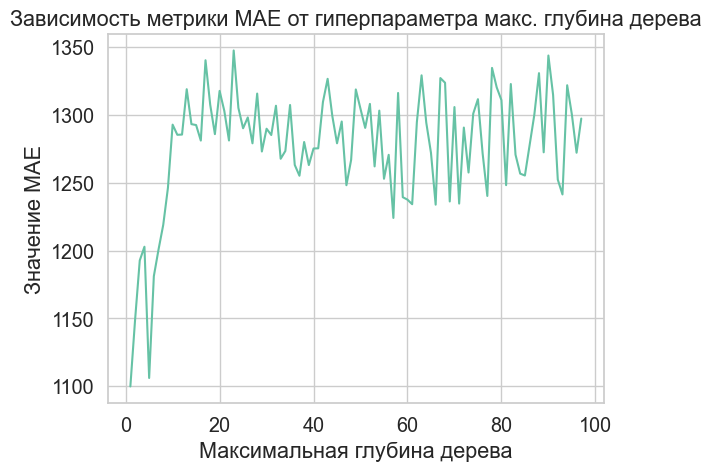

In [167]:
plt.plot([i for i in range(1, 98)], arr_mae)
plt.title('Зависимость метрики MAE от гиперпараметра макс. глубина дерева')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Значение MAE')
None

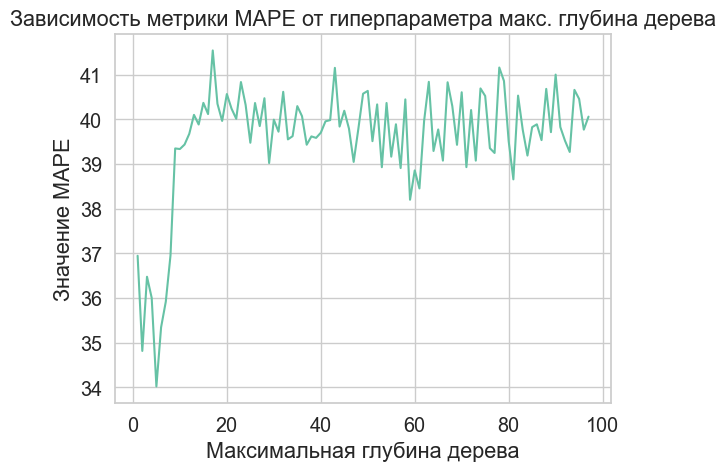

In [168]:
plt.plot([i for i in range(1, 98)], arr_mape)
plt.title('Зависимость метрики MAPE от гиперпараметра макс. глубина дерева')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Значение MAPE')
None

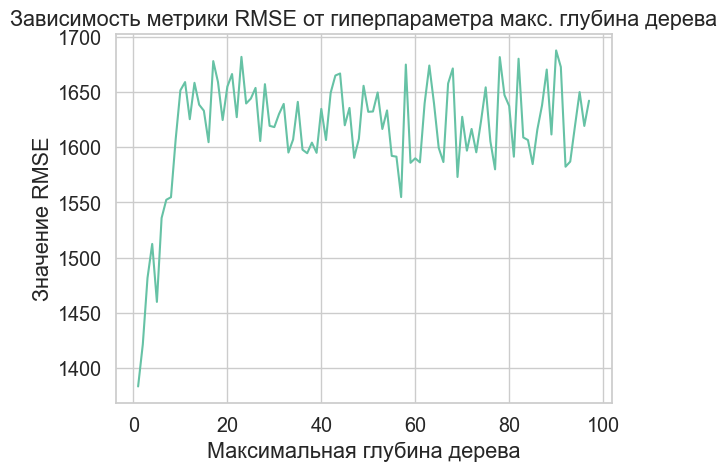

In [169]:
plt.plot([i for i in range(1, 98)], arr_rmse)
plt.title('Зависимость метрики RMSE от гиперпараметра макс. глубина дерева')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Значение RMSE')
None

Найдем оптимальную глубину дерева, то есть параметр, при котором наименьшая ошибка:

In [170]:
np.where(arr_mape == np.min(arr_mape))[0][0] + 1

5

Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

In [171]:
arr_dtr1 = np.array([DecisionTreeRegressor(criterion='absolute_error', max_depth=3, min_samples_leaf = i) for i in range(1, n)])

In [172]:
arr_fit1 = [arr_dtr1[i].fit(X_train, y_train) for i in range(1, n - 1)]

In [173]:
arr_predict1 = [arr_dtr1[i].predict(X_valid) for i in range(1, n - 1)]

In [174]:
arr_mae1 = [mean_absolute_error(y_valid, arr_predict1[i]) for i in range(1, n - 2)]
arr_rmse1 = [root_mean_squared_error(y_valid, arr_predict1[i]) for i in range(1, n - 2)]
arr_mape1 = [mean_absolute_percentage_error(y_valid, arr_predict1[i]) for i in range(1, n - 2)]

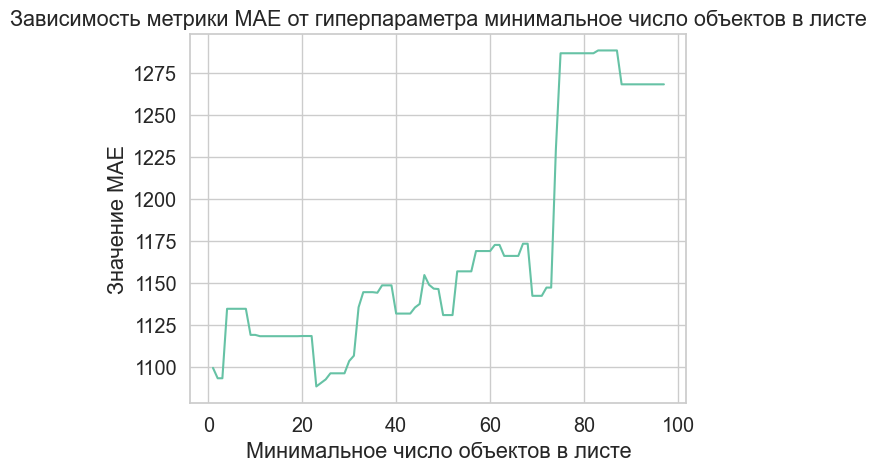

In [175]:
plt.plot([i for i in range(1, 98)], arr_mae1)
plt.title('Зависимость метрики MAE от гиперпараметра минимальное число объектов в листе')
plt.xlabel('Минимальное число объектов в листе')
plt.ylabel('Значение MAE')
None

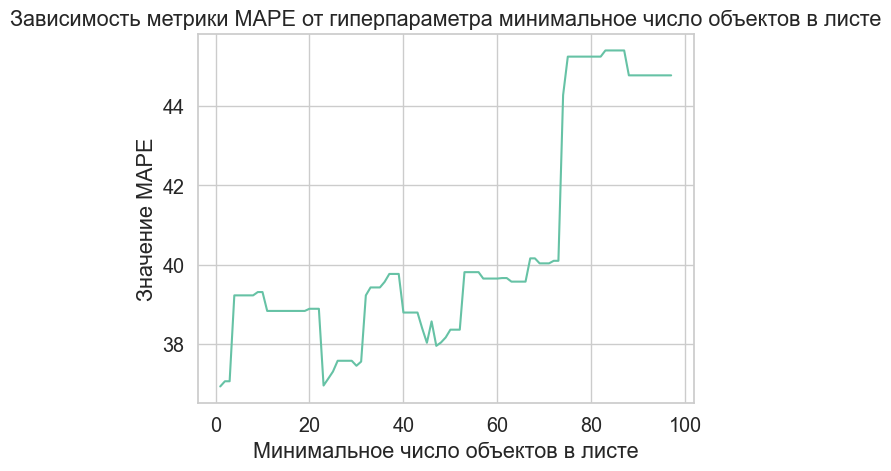

In [176]:
plt.plot([i for i in range(1, 98)], arr_mape1)
plt.title('Зависимость метрики MAPE от гиперпараметра минимальное число объектов в листе')
plt.xlabel('Минимальное число объектов в листе')
plt.ylabel('Значение MAPE')
None

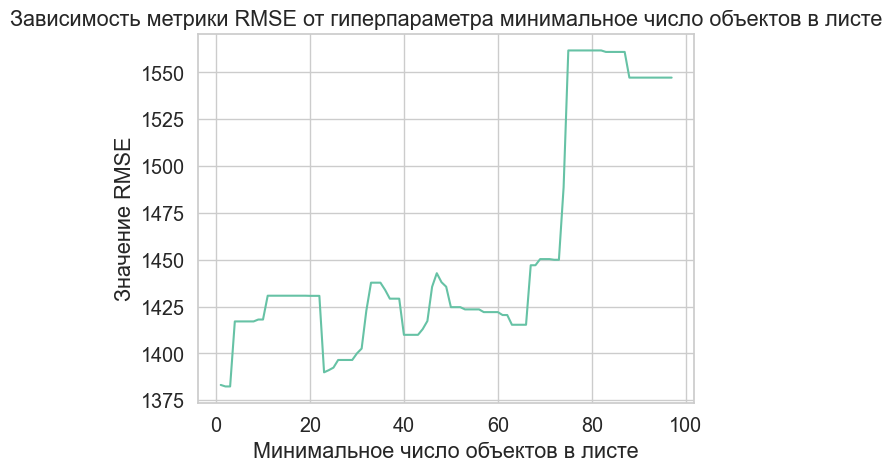

In [177]:
plt.plot([i for i in range(1, 98)], arr_rmse1)
plt.title('Зависимость метрики RMSE от гиперпараметра минимальное число объектов в листе')
plt.xlabel('Минимальное число объектов в листе')
plt.ylabel('Значение RMSE')
None

Найдем оптимальное значение параметра минемального числа объектов в листе, то есть параметр, при котором наименьшая ошибка:

In [178]:
np.where(arr_mape1 == np.min(arr_mape1))[0][0]

0

Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его ошибку на тестовой части выборки.

In [179]:
DecReg = DecisionTreeRegressor(criterion='absolute_error', max_depth=4, min_samples_leaf = 15)

In [180]:
DecReg.fit(X_train, y_train)
None

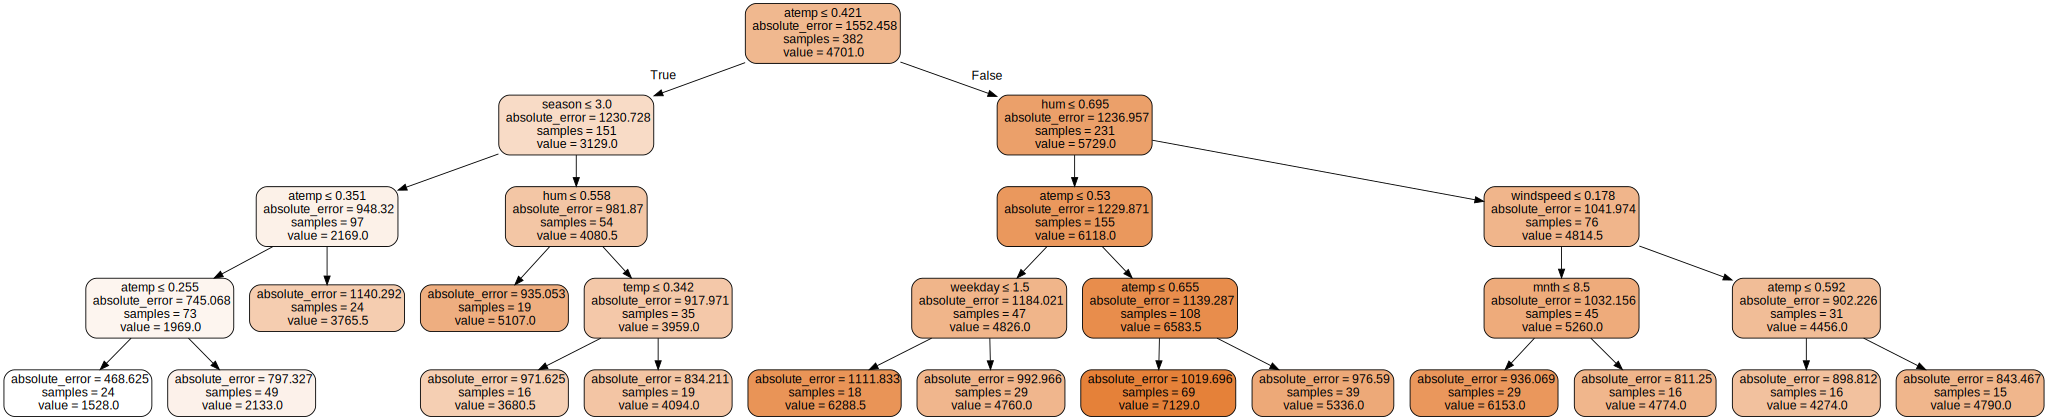

In [181]:
dot_data1 = export_graphviz(DecReg, class_names='cnt',
                               feature_names=X_train.columns, filled=True, 
                               rounded=True, special_characters=True)
graph = graphviz.Source(dot_data1)
graph.format = "pdf"
graph.render("tree_optimal")
graph

Теперь посчитаем метрики ошибки дерева на тестовой части выборки:

In [182]:
prediction = DecReg.predict(X_test)

In [183]:
mean_absolute_percentage_error(y_test, prediction)

182.91090811519405

Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

In [184]:
DecReg.feature_importances_

array([0.00303168, 0.67514683, 0.07876168, 0.01974522, 0.1688808 ,
       0.0261436 , 0.        , 0.02829018, 0.        , 0.        ])

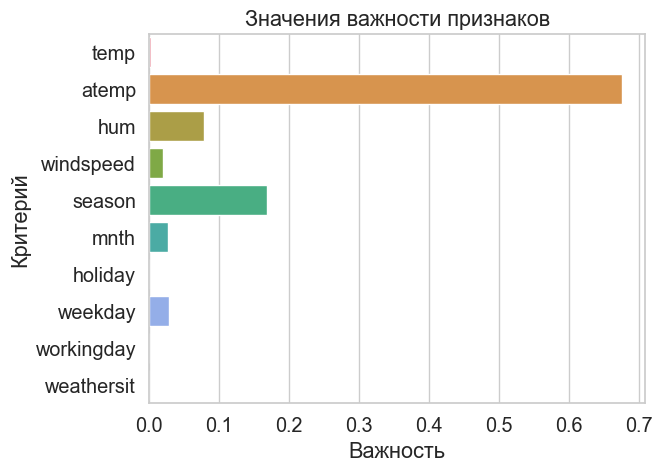

In [185]:
sns.barplot(DecReg.feature_importances_, X_train.columns)
plt.title('Значения важности признаков')
plt.xlabel('Важность')
plt.ylabel('Критерий')
None

**Вывод:**

Мы построили и обучили решающее дерево глубины 3, визуализировали его. Далее, построили графики метрики ошибок в зависимости от гиперпараметров, таких как глубина дерева и минимальное количество объектов в листе. По графику определили оптимальные значения данных параметров. После этого уже по оптимальным гиперпараметрам построили и визуализировали решающее дерево.

А также посмотрели на важность каждого признака, которое можно определить по решающему дереву. Получили, что наиболее важные признаки это температура по ощущениям, влажность, месяц, сезон, скорость ветра. А это очень логично, так как эти признаки наиболее важны при решении человека пойти ли кататься на велосипеде.

---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [186]:
n = 500
model = RandomForestRegressor(n_estimators=n, warm_start=True)
model.fit(X_train, y_train)
None

Постройте график зависимости ошибки модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у *обученной* модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`. Обратите внимание, что это приватное поле объекта, и менять его очень плохо, за такое баллы будут снижаться.

Для начала посчитаем значения MAPE для всего леса

In [187]:
pred_valid = model.predict(X_valid)
mean_absolute_percentage_error(y_valid, pred_valid)

32.27915563162323

In [188]:
pred_train = model.predict(X_train)
mean_absolute_percentage_error(y_train, pred_train)

9.83569769146853

Далее через цикл посчитаем зависимость различных метрик от количества деревьев в лесу: 

In [189]:
answ_valid = np.array([])
answ_train = np.array([])
for i in range(500):
    pred_valid = model.estimators_[i].predict(X_valid)
    answ_valid = np.append(answ_valid, pred_valid)
    pred_train = model.estimators_[i].predict(X_train)
    answ_train = np.append(answ_train, pred_train)
answ_valid = answ_valid.reshape((500, y_valid.shape[0]))
answ_train = answ_train.reshape((500, y_train.shape[0]))

In [190]:
result_valid_MAPE = []
result_train_MAPE = []
result_valid_MAE = []
result_train_MAE = []
result_valid_RMSE = []
result_train_RMSE = []
for i in range(1, 500):
    tmp_valid = np.mean(answ_valid[:i, :], axis=0)
    tmp_train = np.mean(answ_train[:i, :], axis=0)
    result_train_MAPE.append(mean_absolute_percentage_error(y_train, tmp_train))
    result_valid_MAPE.append(mean_absolute_percentage_error(y_valid, tmp_valid))
    result_valid_MAE.append(mean_absolute_error(y_valid, tmp_valid))
    result_train_MAE.append(mean_absolute_error(y_train, tmp_train))
    result_valid_RMSE.append(root_mean_squared_error(y_valid, tmp_valid))
    result_train_RMSE.append(root_mean_squared_error(y_train, tmp_train))

Построим графики зависимости метрик MAPE, RMSE, MAE от количества деревьев:

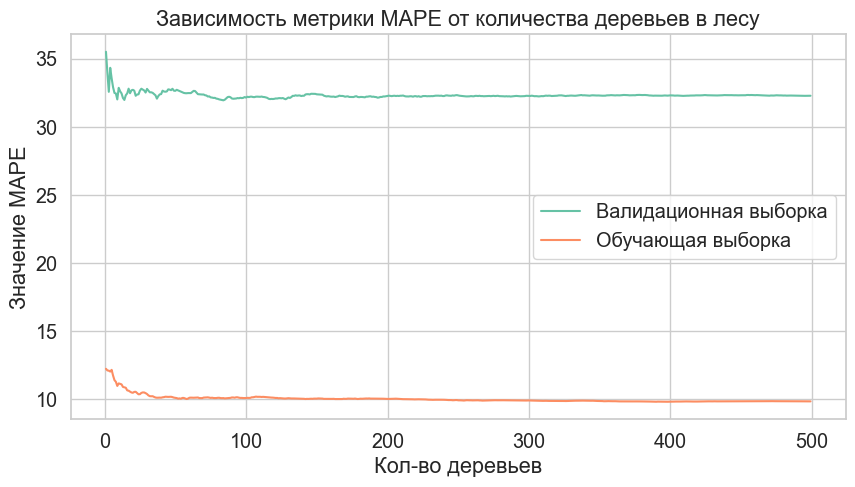

In [191]:
ax, fig = plt.subplots(figsize=(10,5))
plt.plot([i for i in range(1, 500)], result_valid_MAPE)
plt.plot([i for i in range(1, 500)], result_train_MAPE)
plt.legend(['Валидационная выборка', 'Обучающая выборка'])
plt.title('Зависимость метрики MAPE от количества деревьев в лесу')
plt.xlabel('Кол-во деревьев')
plt.ylabel('Значение MAPE')
None

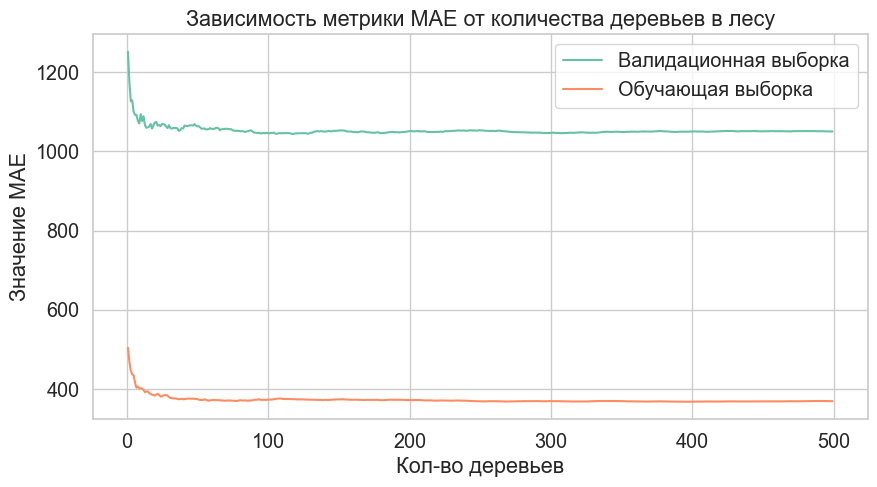

In [192]:
ax, fig = plt.subplots(figsize=(10,5))
plt.plot([i for i in range(1, 500)], result_valid_MAE)
plt.plot([i for i in range(1, 500)], result_train_MAE)
plt.legend(['Валидационная выборка', 'Обучающая выборка'])
plt.title('Зависимость метрики MAE от количества деревьев в лесу')
plt.xlabel('Кол-во деревьев')
plt.ylabel('Значение MAE')
None

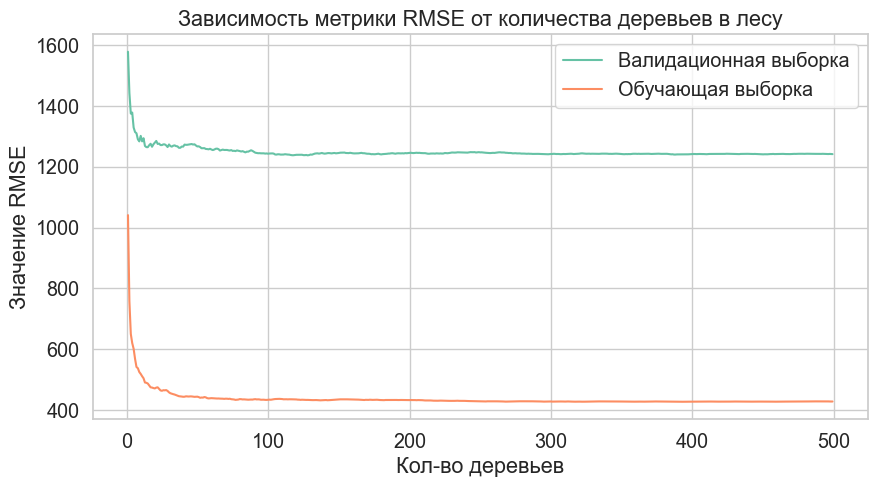

In [193]:
ax, fig = plt.subplots(figsize=(10,5))
plt.plot([i for i in range(1, 500)], result_valid_RMSE)
plt.plot([i for i in range(1, 500)], result_train_RMSE)
plt.legend(['Валидационная выборка', 'Обучающая выборка'])
plt.title('Зависимость метрики RMSE от количества деревьев в лесу')
plt.xlabel('Кол-во деревьев')
plt.ylabel('Значение RMSE')
None

Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

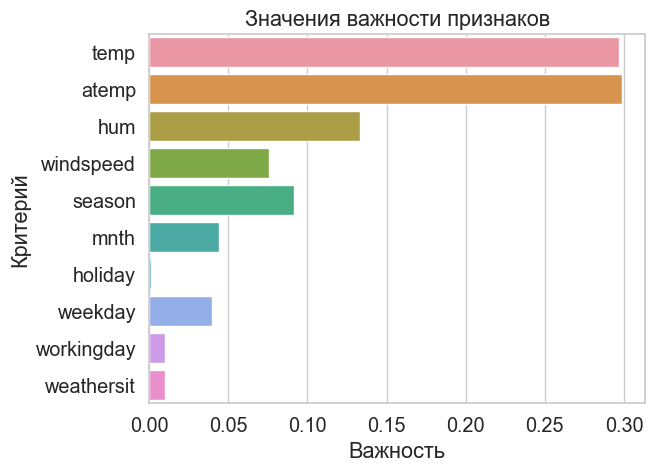

In [194]:
sns.barplot(model.feature_importances_, X_train.columns)
plt.title('Значения важности признаков')
plt.xlabel('Важность')
plt.ylabel('Критерий')
None

**Вывод:**

Мы обучили случайный лес на 500 деревьев, построили графики метрик ошибки в зависимости от количества деревьев для обучающей и валидационной выборок. Проанализировав получившийся график выявили, что при количестве деревьев примерно в 50 штук лес уже имеет ошибку, близкую к оптимальной.

Также мы провизуализировали важности признаков и получили весьма логичные результаты, как в прошлом задании.

В результате проделанной работы, можно сделать вывод, что при использовании леса, точность предсказаний значительно лучше, чем при использовании одного дерева.